In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math as m


from numpy import dot, diag
from numpy import real, imag
from numpy.linalg import inv, eig
from scipy.linalg import svd
from scipy import integrate
from sklearn.decomposition import PCA
from numpy import linalg as la

# !pip install colab-dev-tools
# install plotly

understand dynamic modes - what do they mean
plot the phase of each state, maybe ordered in some way


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving jhuGlobalTimeSeries.csv to jhuGlobalTimeSeries.csv


In [ ]:
df = pd.read_csv('jhuGlobalTimeSeries.csv')
del df['Lat']
del df['Long']
del df['Province/State']
df = df[1:]
dfT = df.T.iloc[1: , :]
df.columns = df.iloc[0] 

dfDaily = dfT.apply(pd.to_numeric).diff().iloc[1:, :]

dfDaily.drop(index=dfDaily.index[-1], 
        axis=0,
        inplace = True)

dfDaily[dfDaily < 0] = 0

dfDaily.index = pd.RangeIndex(len(dfDaily.index))


print(dfDaily.info())
print(dfDaily.tail())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Columns: 284 entries, 1 to 284
dtypes: float64(284)
memory usage: 1.9 MB
None
      1    2      3     4    5     6        7    8      9        10   ...  \
853  46.0  2.0  322.0  94.0  0.0  80.0      0.0  0.0  884.0  10899.0  ...   
854  27.0  2.0    0.0   0.0  0.0  57.0      0.0  0.0  823.0   8654.0  ...   
855  36.0  6.0    0.0   0.0  0.0   0.0      0.0  0.0  822.0   7460.0  ...   
856  33.0  3.0    0.0   0.0  0.0   0.0      0.0  0.0  579.0   6508.0  ...   
857  20.0  0.0    0.0   0.0  0.0   0.0  51778.0  0.0    0.0   5830.0  ...   

     275   276   277   278     279  280  281  282    283    284  
853  0.0  19.0  72.0   0.0  1344.0  0.0  0.0  0.0   74.0  299.0  
854  0.0  11.0  51.0  33.0  1275.0  0.0  0.0  0.0   57.0  418.0  
855  0.0   8.0  47.0  96.0  1239.0  0.0  0.0  0.0  104.0  313.0  
856  0.0   0.0  19.0  53.0  1114.0  0.0  0.0  0.0    0.0    0.0  
857  0.0   0.0  81.0  25.0   890.0  0.0  0.0  0.0    0.0 

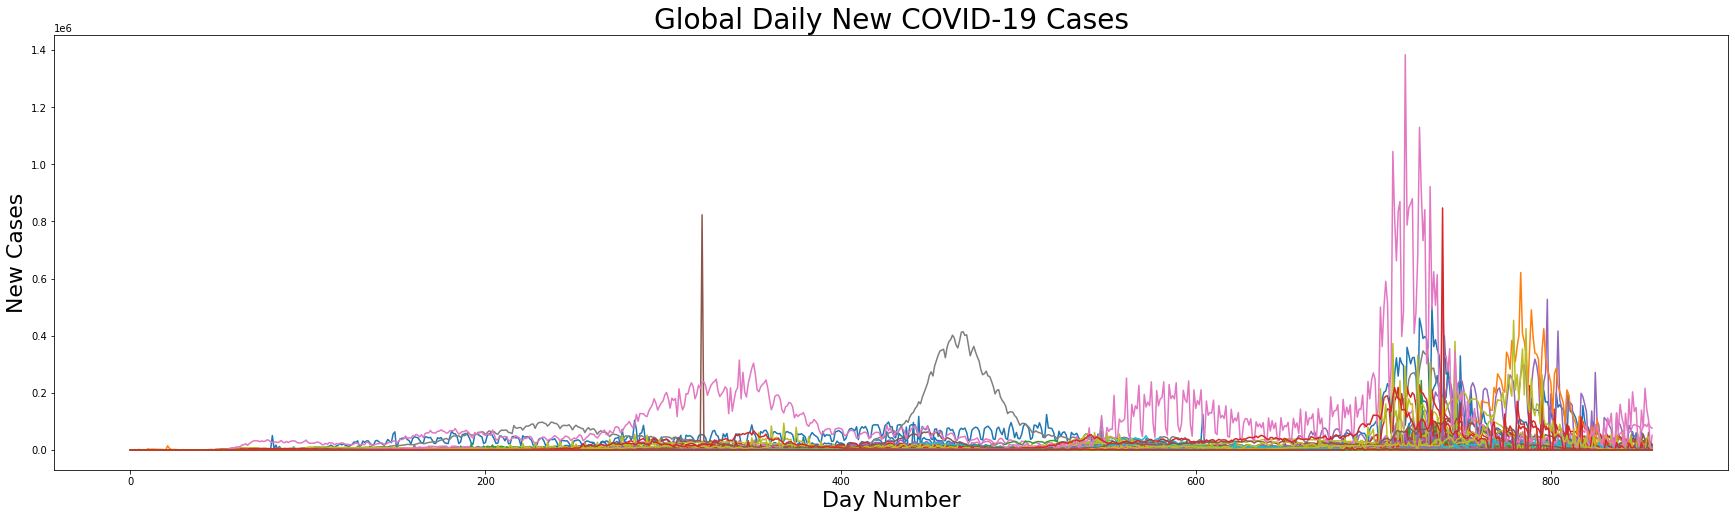

In [ ]:
# plot raw data

dfDaily.plot(figsize = (30,8),legend = False)


plt.xlabel('Day Number', fontsize = 22)
plt.ylabel('New Cases', fontsize = 22)
plt.title('Global Daily New COVID-19 Cases',fontsize = 28)
plt.show()

RangeIndex(start=0, stop=858, step=1)


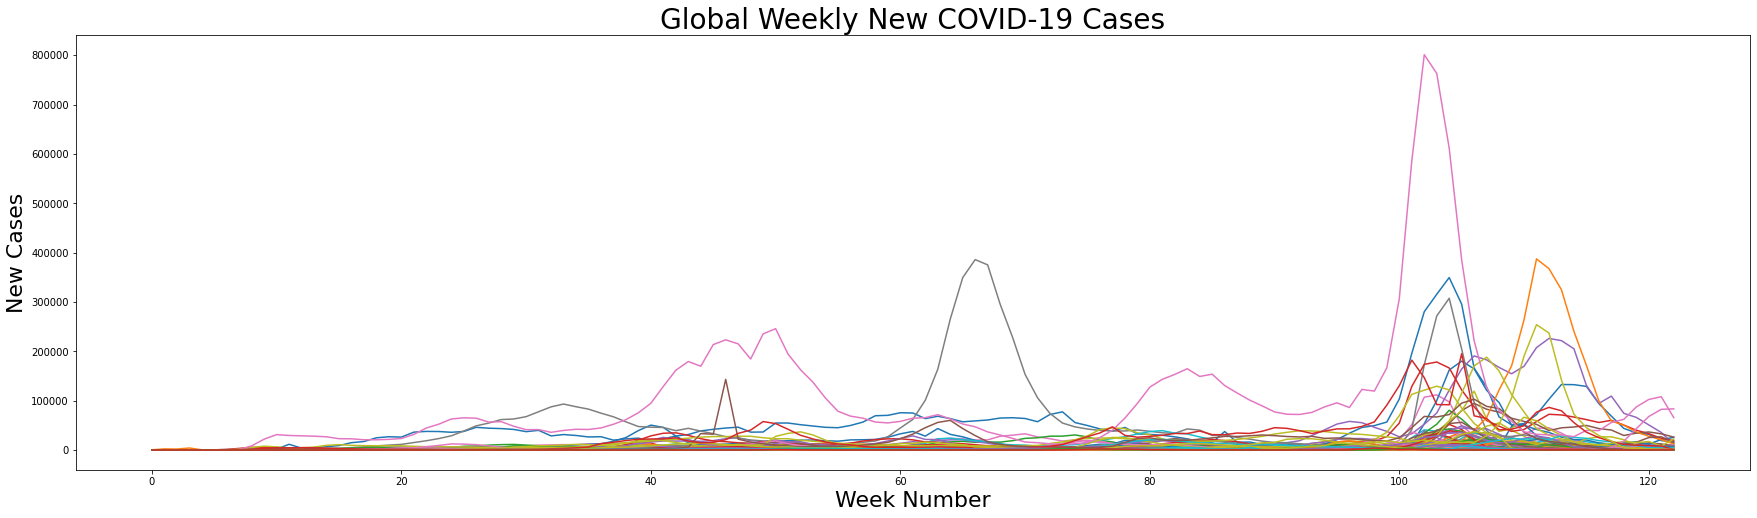

In [ ]:
# create and plot the same time series but in condensed weekly incremements
print(dfDaily.index)

dfW = dfDaily.groupby(dfDaily.index // 7).mean()
dfW.plot(figsize = (30,8),legend = False)
plt.xlabel('Week Number', fontsize = 22)
plt.ylabel('New Cases', fontsize = 22)
plt.title('Global Weekly New COVID-19 Cases',fontsize = 28)
plt.show()

In [ ]:
# Define DMD function

def dmd(X, Xprime, truncations=None):
    U2,sigma,Vh = svd(X, False) # calculate singular value decomposition of X
    r = len(sigma) if truncations is None else truncations # choose rank truncation
    Utrunc = U2[:,:r] #truncate U matrix
    Smat = diag(sigma)[:r,:r] #convert singular values (Sigma) into an appropriate diagonal matrix
    Vtrunc = Vh.conj().T[:,:r] # truncate V matrix
    Atil = dot(dot(dot(Utrunc.conj().T, Xprime), Vtrunc), inv(Smat)) #  A tilde
    mu,Ustar = eig(Atil) # eigenvalues (mu) and eigenvectors (Ustar)
    Phi = dot(dot(dot(Xprime, Vtrunc), inv(Smat)), Ustar) #  DMD modes
    return mu, Phi, sigma


In [ ]:
# define matrices for DMD

# with raw data
X = dfDaily.to_numpy()[:-1,:].T
Xprime = dfDaily.to_numpy()[1:,:].T

# with weekly data
XW = (dfW.to_numpy()[:-1,:]).T
XprimeW = (dfW.to_numpy()[1:,:]).T


print(X.T)
# run DMD on raw data
mu, Phi, s = dmd(Xprime, X, truncations = 30)

# run DMD on weekly data
muW, PhiW, sW = dmd(XprimeW, XW, truncations = 30)


[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [ 27.   2.   0. ...   0.  57. 418.]
 [ 36.   6.   0. ...   0. 104. 313.]
 [ 33.   3.   0. ...   0.   0.   0.]]


Text(0.5, 1.0, 'Global Daily Eigenvalue Spectrum')

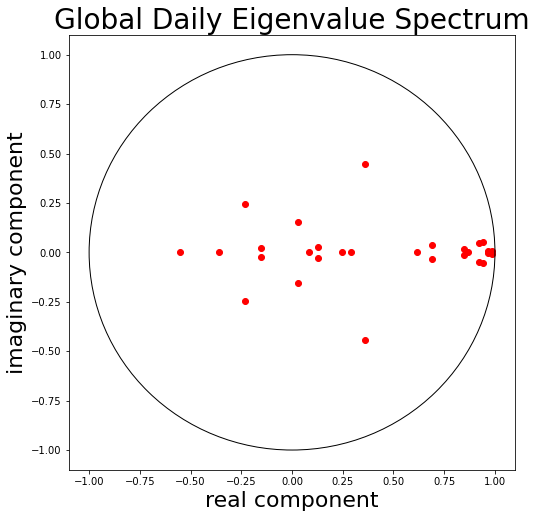

In [ ]:
# plotting the eigenvalues for raw data

# extract real part
xEig = [ele.real for ele in mu]
# extract imaginary part
yEig = [ele.imag for ele in mu]

plt.figure(figsize = (8,8))
ax = plt.scatter(xEig, yEig, color = 'red')
fig = plt.gcf()
ax = fig.gca()
circle = plt.Circle((0, 0 ), 1 ,fill = False ) 
ax.add_patch(circle)
# ax.axhline(y=0, color='k')
# ax.axvline(x=0, color='k')
plt.xlabel('real component',fontsize = 22)
plt.ylabel('imaginary component',fontsize = 22)
plt.title("Global Daily Eigenvalue Spectrum",fontsize = 28 )

Text(0.5, 1.0, 'Global Weekly Eigenvalue Spectrum')

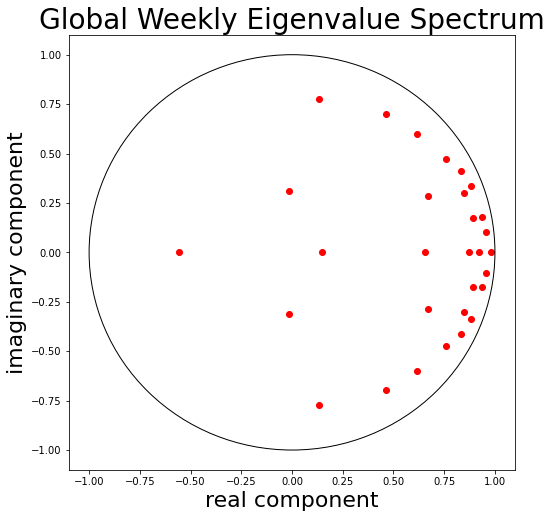

In [ ]:
# plotting the eigenvalues for weekly data

# extract real part
xEigW = [ele.real for ele in muW]
# extract imaginary part
yEigW = [ele.imag for ele in muW]

plt.figure(figsize = (8,8))
ax = plt.scatter(xEigW, yEigW, color = 'red')
fig = plt.gcf()
ax = fig.gca()
circle = plt.Circle((0, 0 ), 1 ,fill = False ) 
ax.add_patch(circle)
# ax.axhline(y=0, color='k')
# ax.axvline(x=0, color='k')
plt.xlabel('real component',fontsize = 22)
plt.ylabel('imaginary component',fontsize = 22)
plt.title("Global Weekly Eigenvalue Spectrum",fontsize = 28 )

In [ ]:
# normalization of raw time series


# normX = (X - X.mean(axis=1, keepdims=True)) / np.var(X,axis = 1)[:,None]
# normX = (X-np.mean(X))/(np.std(X))
normX = (X-np.min(X))/(np.max(X)-np.min(X))
print(np.max(normX))

# shrink data on a scale between 0 and 1
# logarithm?

1.0


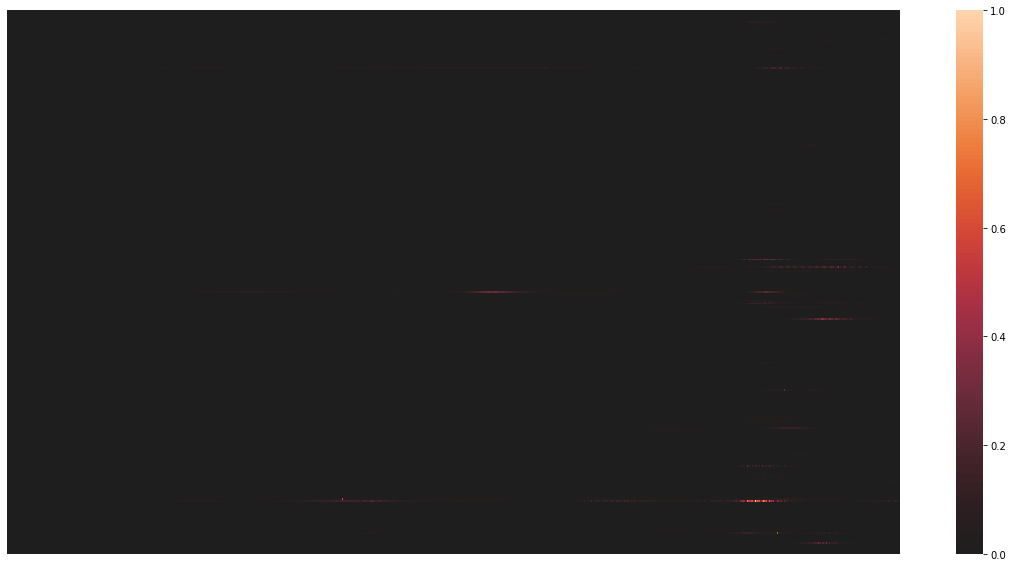

In [ ]:
plt.figure(figsize=(20,10))
fig = sns.heatmap(normX,center=0,vmin=0, vmax=1,xticklabels = False, yticklabels = False)


In [ ]:
# normalization of weekly time series


# normXW = (XW - XW.mean(axis=1, keepdims=True)) / np.var(XW,axis = 1)[:,None]
# normXW = (XW-np.mean(XW))/(np.std(XW))
normXW = (XW-np.min(XW))/(np.max(XW)-np.min(XW))
print(np.max(normXW))

# shrink data on a scale between 0 and 1
# logarithm?

1.0


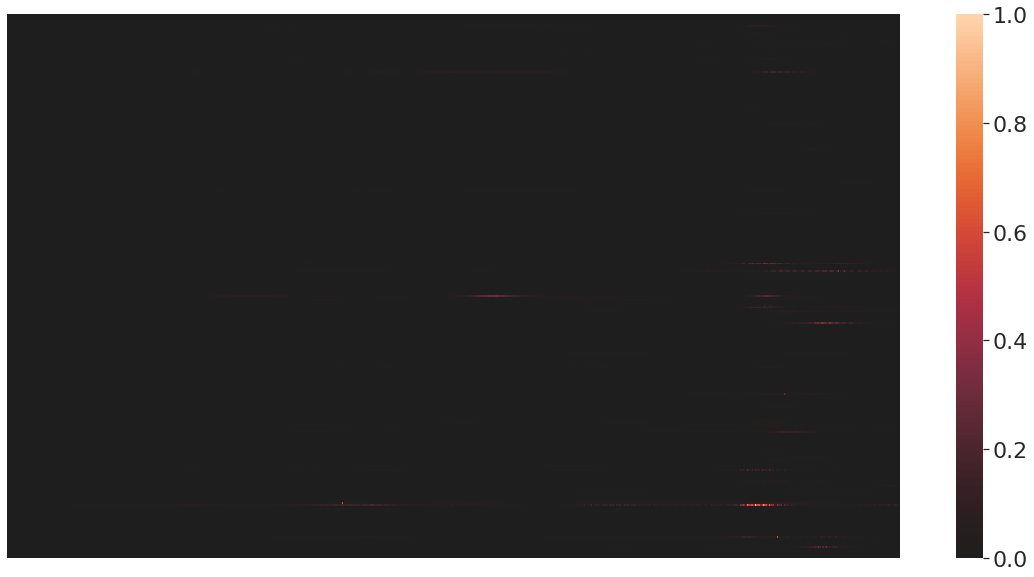

In [ ]:
sns.set(font_scale = 2)

plt.figure(figsize=(20,10))
fig = sns.heatmap(normX,center=0,vmin=0, vmax=1,xticklabels = False, yticklabels = False)


Text(0.5, 0, 'singular value index')

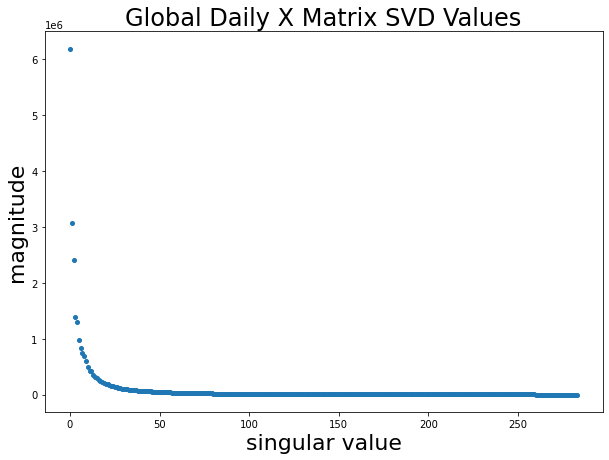

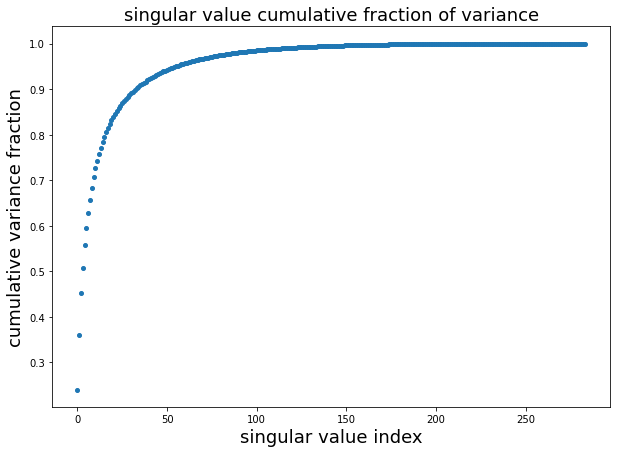

In [ ]:
# raw time series
# trying out different ways of showing the singular values 
# goal: decide on a truncation method

plt.figure(figsize = (10,7))
plt.xlabel('singular value', fontsize = 22)
plt.ylabel('magnitude', fontsize = 22)
plt.title('Global Daily X Matrix SVD Values', fontsize = 24)
plt.plot(s,'.',markersize=8)


cumulative_s = np.array([])
plt.figure(figsize = (10,7))
plt.plot(range(0,284),np.cumsum(s) / np.sum(s),'.',markersize = 8)
plt.title('singular value cumulative fraction of variance', fontsize = 18)
plt.ylabel('cumulative variance fraction', fontsize = 18)
plt.xlabel('singular value index', fontsize = 18)


# # choose elbow of this plot
# log_s = np.log(s)
# plt.figure(figsize = (10,7))
# plt.xlabel('singular value', fontsize = 18)
# plt.ylabel('nat log singular value', fontsize = 18)
# plt.title('United States X Matrix ln SVD Values', fontsize = 18)
# plt.plot(s,log_sW,'.',markersize=8)

ValueError: ignored

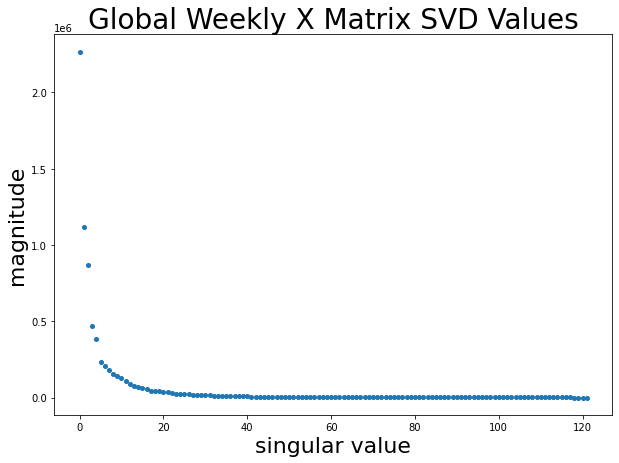

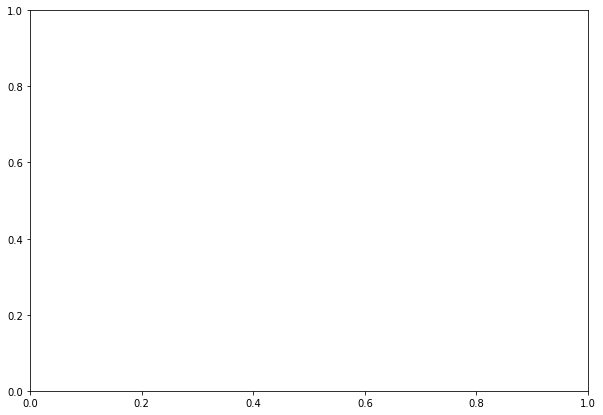

In [ ]:
# weekly time series
# trying out different ways of showing the singular values 
# goal: decide on a truncation method

plt.figure(figsize = (10,7))
plt.xlabel('singular value', fontsize = 22)
plt.ylabel('magnitude', fontsize = 22)
plt.title('Global Weekly X Matrix SVD Values', fontsize = 28)
plt.plot(sW,'.',markersize=8)


cumulative_sW = np.array([])
plt.figure(figsize = (10,7))
plt.plot(range(0,112),np.cumsum(sW) / np.sum(sW),'.',markersize = 8)
plt.title('singular value cumulative fraction of variance', fontsize = 18)
plt.ylabel('cumulative variance fraction', fontsize = 18)
plt.xlabel('singular value index', fontsize = 18)


# choose elbow of this plot
log_sW = np.log(sW)
plt.figure(figsize = (10,7))
plt.xlabel('singular value', fontsize = 18)
plt.ylabel('nat log singular value', fontsize = 18)
plt.title('United States X Matrix ln SVD Values', fontsize = 18)
plt.plot(sW,log_sW,'.',markersize=8)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


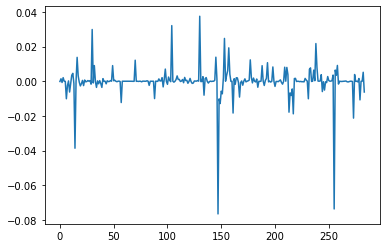

In [ ]:
plt.plot(PhiW[:,3])

In [ ]:
# mode selection frequency
def freq(x):
  deltaT = 0.1
  frequency = abs(((m.log(abs(x)))/1)/(2*m.pi))
  return frequency

[ 0.24621348 -0.24621348  0.44530425 -0.44530425  0.02341245 -0.02341245
  0.15362757 -0.15362757  0.02792594 -0.02792594  0.03556529 -0.03556529
  0.01510008 -0.01510008  0.04686103 -0.04686103  0.05202067 -0.05202067
  0.00728194 -0.00728194  0.00441758 -0.00441758]
[0.22306461 0.22306461 0.12875595 0.12875595 0.59754521 0.59754521
 0.29813285 0.29813285 0.56948809 0.56948809 0.53100217 0.53100217
 0.66734552 0.66734552 0.48710467 0.48710467 0.47048017 0.47048017
 0.7834175  0.7834175  0.86296397 0.86296397]


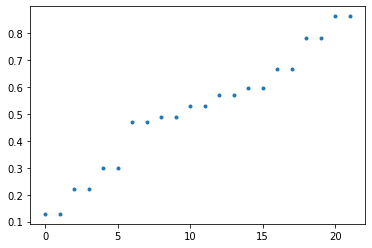

In [ ]:
# Frequency of raw time series dmd output

imagMu = imag(mu)
noZeroMu = imagMu[imagMu != 0]
print(noZeroMu)
frequencies = []
for i in noZeroMu:
  frequ = freq(i)
  frequencies = np.append(frequencies,frequ)
print(frequencies)
frequencies = np.sort(frequencies)
plt.plot(frequencies,'.')


[ 0.77406895 -0.77406895  0.31155198 -0.31155198  0.69808696 -0.69808696
  0.59995431 -0.59995431  0.47258872 -0.47258872  0.41119989 -0.41119989
  0.28548229 -0.28548229  0.33801088 -0.33801088  0.29920201 -0.29920201
  0.17650095 -0.17650095  0.17622256 -0.17622256  0.10355296 -0.10355296]
[0.04075868 0.04075868 0.18560476 0.18560476 0.05720213 0.05720213
 0.08131254 0.08131254 0.11929137 0.11929137 0.14143715 0.14143715
 0.1995127  0.1995127  0.17263174 0.17263174 0.19204213 0.19204213
 0.27604295 0.27604295 0.27629418 0.27629418 0.36091122 0.36091122]


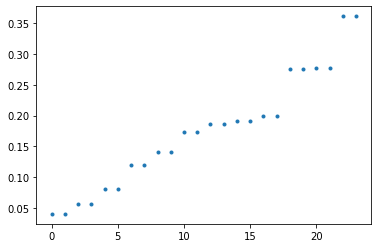

In [ ]:
# Frequency of weekly time series 
imagMuW = imag(muW)
noZeroMuW = imagMuW[imagMuW != 0]
print(noZeroMuW)
frequenciesW = []
for i in noZeroMuW:
  frequW = freq(i)
  frequenciesW = np.append(frequenciesW,frequW)
print(frequenciesW)
frequenciesW = np.sort(frequenciesW)
plt.plot(frequenciesW,'.')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0.5, 1.0, 'Global Weekly Mode Selection')

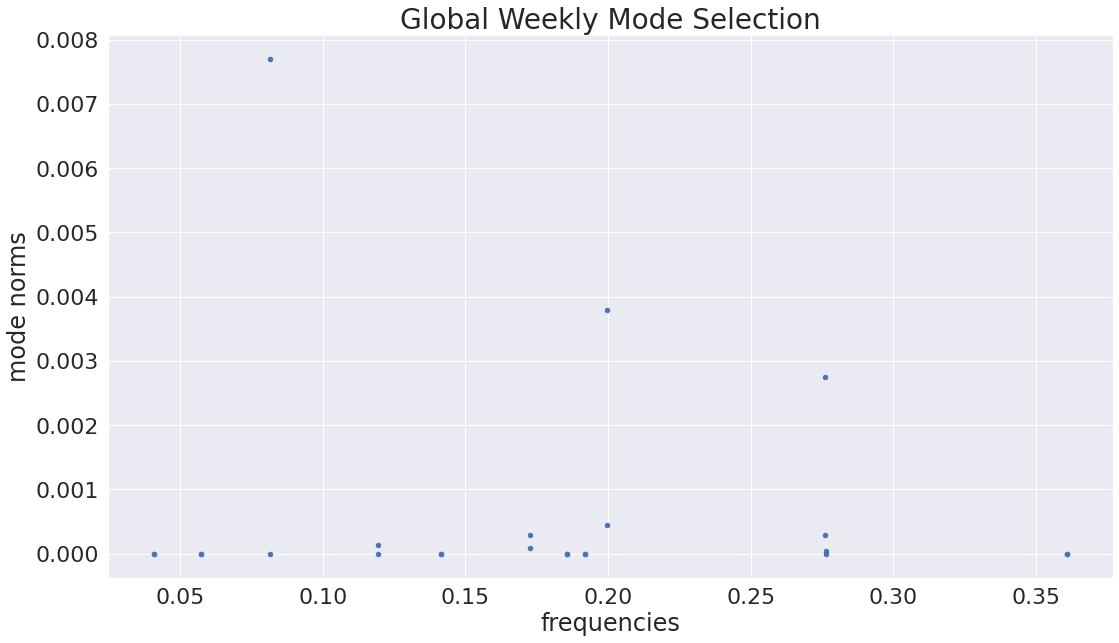

In [ ]:
# norms of dynamic modes
normPhiW = []
for column in PhiW:
  normPhiW = np.append(normPhiW,la.norm(column))
noZerosNormPhiW =  normPhiW[0:30][imagMuW != 0]

# mode selection
modeSelectionW = []
p = 20
for (lambdaJ,phiJ) in zip(muW, noZerosNormPhiW):
  metric = (lambdaJ**p)*la.norm(phiJ)
  modeSelectionW = np.append(modeSelectionW, metric)

selections = {'frequencies':frequenciesW, 'mode norms': modeSelectionW}
selectionDF = pd.DataFrame(selections, columns = ['frequencies','mode norms'])
selectionDFsorted =selectionDF.sort_values(by = ['frequencies'])

# selectionArray = np.concatenate(frequenciesW,modeSelectionW)
# print(selectionArray)

# selectionDF = pd.DataFrame(my_array, columns = ['Column_A','Column_B','Column_C'])

selectionDFsorted[selectionDFsorted < 0] = 0

selectionDFsorted.plot('frequencies','mode norms','scatter',figsize = (18,10))
plt.title('Global Weekly Mode Selection',fontsize=28)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0.5, 1.0, 'Global Daily Mode Selection')

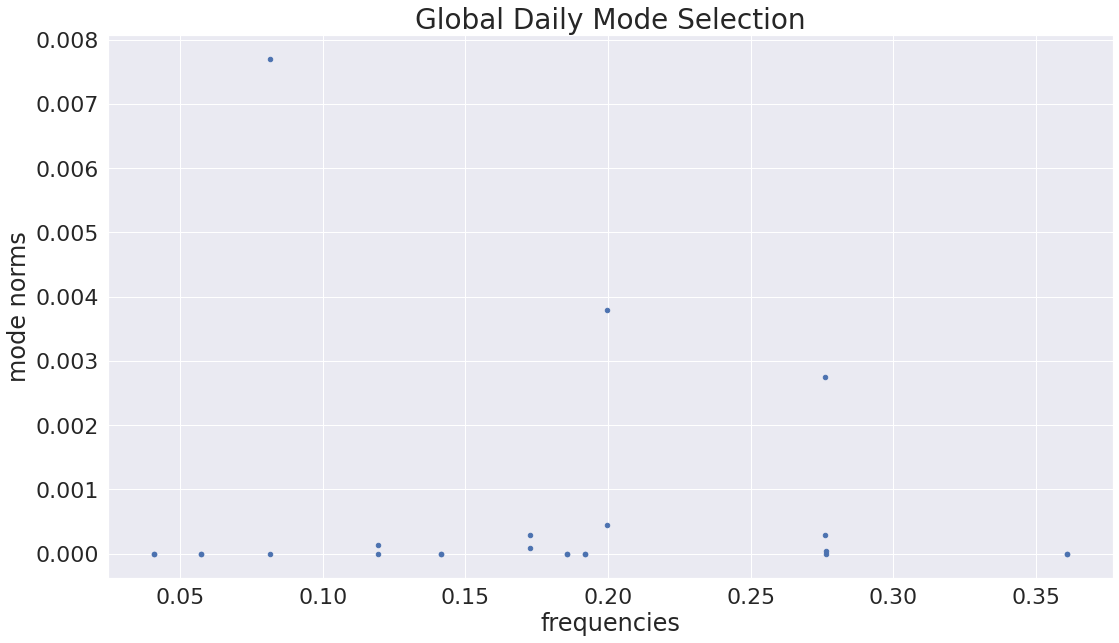

In [ ]:
# norms of dynamic modes daily data
normPhiD = []
for column in Phi:
  normPhiD = np.append(normPhiD,la.norm(column))
noZerosNormPhiD =  normPhiD[0:30][imagMu != 0]

# mode selection
modeSelectionD = []
p = 20
for (lambdaJ,phiJ) in zip(mu, noZerosNormPhiW):
  metric = (lambdaJ**p)*la.norm(phiJ)
  modeSelectionD = np.append(modeSelectionD, metric)

selectionsD = {'frequencies':frequencies, 'mode norms': modeSelectionD}
selectionDDF = pd.DataFrame(selections, columns = ['frequencies','mode norms'])
selectionDDFsorted =selectionDDF.sort_values(by = ['frequencies'])

# selectionArray = np.concatenate(frequenciesW,modeSelectionW)
# print(selectionArray)

# selectionDF = pd.DataFrame(my_array, columns = ['Column_A','Column_B','Column_C'])

selectionDDFsorted[selectionDDFsorted < 0] = 0

selectionDDFsorted.plot('frequencies','mode norms','scatter',figsize = (18,10))
plt.title('Global Daily Mode Selection',fontsize=28)
